---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# Model Classes

> Model classes

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp utils.model_classes

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| export
from abc import ABC, abstractmethod
from pathlib import Path
from collections.abc import Sequence
from typing import (
  Callable, Generic, 
  TypeVar, Union, 
  Protocol, Dict,
  TypeAlias)
import types

import xarray as xr

from budget_optimizer.utils.model_helpers import (
  load_module,
  AbstractModel,
  BudgetType
)

In [ ]:
#| export
class BaseBudgetModel(AbstractModel):
    """
    Abstract class for all models
    """
    _FUNCTION_MODULE_NAME = "model_config.py"
    
    def __init__(
      self, 
      model_name: str, # Name used to identify the model
      model_kpi: str, # Key performance indicator output by the model predict
      model_path: str|Path, # Path to the model artifact
    ):
        self.model_name: str = model_name
        self.model_kpi: str = model_kpi
        self.model_path: Path = model_path if isinstance(model_path, Path) else Path(model_path)
        self._model: AbstractModel = self._get_model_loader()(model_path)
        self._budget_to_data: xr.Dataset = self._get_budget_to_data()

    def _get_model_loader(self) -> Callable[str|Path, AbstractModel]:
        """
        Get the function to load the model from the path
        """
        module = load_module(
            self._FUNCTION_MODULE_NAME.replace(".py", ""),
            self.model_path / self._FUNCTION_MODULE_NAME
            )
        return module.model_loader
    
    def _get_budget_to_data(self) -> Callable[BudgetType, xr.Dataset]:
        """
        Get the mapping from budget keys to data keys
        """
        
        module = load_module(
            self._FUNCTION_MODULE_NAME.replace(".py", ""), 
            self.model_path / self._FUNCTION_MODULE_NAME
            )
        
        return module.budget_to_data
    
    def predict(
        self, 
        budget: BudgetType # Budget
        ) -> xr.DataArray: # Predicted target variable
        """
        Predict the target variable from the input data
        """
        data = self._budget_to_data(budget, self._model)
        return self._model.predict(data)
    
    
    def contributions(
        self, 
        budget: BudgetType # Budget
        ) -> xr.Dataset: # Contributions of the input data to the target variable
        """
        Get the contributions of the input data to the target variable
        """
        data = self._budget_to_data(budget, self._model)
        return self._model.contributions(data)

In [ ]:
class BudgetModel(BaseBudgetModel):
    """
    Budget model class
    """
    ...

In [ ]:
m = BudgetModel("Revenue Model", "Revenue", "../../example_files/fast_model")

In [ ]:
show_doc(BaseBudgetModel.predict)

---

[source](https://github.com/redam94/budget_optimizer/blob/main/budget_optimizer/utils/model_classes.py#L68){target="_blank" style="float:right; font-size:smaller"}

### BaseBudgetModel.predict

>      BaseBudgetModel.predict
>                               (budget:Union[Dict[str,float],xarray.core.datase
>                               t.Dataset])

*Predict the target variable from the input data*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| budget | Union | Budget |
| **Returns** | **DataArray** | **Predicted target variable** |

In [ ]:
budget = {"a": 2, "b": .3}
prediction = m.predict(budget)

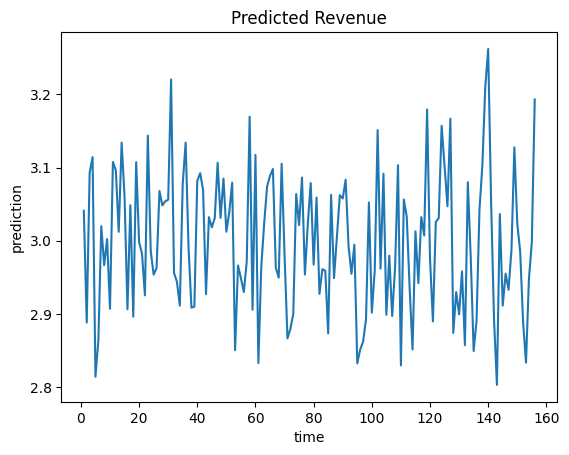

In [ ]:
#| echo: false
prediction.plot()
plt.title("Predicted Revenue");

In [ ]:
show_doc(BaseBudgetModel.contributions)

---

[source](https://github.com/redam94/budget_optimizer/blob/main/budget_optimizer/utils/model_classes.py#L79){target="_blank" style="float:right; font-size:smaller"}

### BaseBudgetModel.contributions

>      BaseBudgetModel.contributions
>                                     (budget:Union[Dict[str,float],xarray.core.
>                                     dataset.Dataset])

*Get the contributions of the input data to the target variable*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| budget | Union | Budget |
| **Returns** | **Dataset** | **Contributions of the input data to the target variable** |

In [ ]:
contributions = m.contributions(budget)

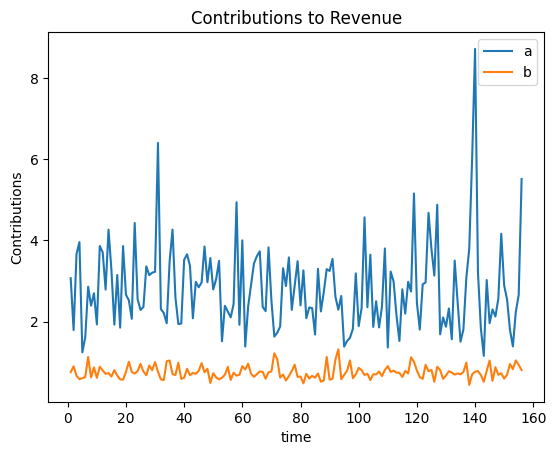

In [ ]:
#| echo: false
contributions.a.plot(label="a")
contributions.b.plot(label="b")
plt.ylabel("Contributions")
plt.legend()
plt.title("Contributions to Revenue");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()